# Validate PyBaMM with real results.

Nesse notebook, queremos validar o modelo PyBaMM usando dados experimentais reais -- nesse caso, temos o dataset *Severson (2019)*.


O primeiro passo é preparar o código, caso esteja sendo executado no Google Colab ou localmente.

In [53]:
# importing basic libs
import os
import sys

# setting up code to run in google colab
git_repo_url = "https://github.com/SarvTex/june_sciml_workshop.git"
repo_name = "june_sciml_workshop"

if 'google.colab' in sys.modules:
    # Google colab setup
    print("> Code running in Colab env ===")

    if not repo_name in os.getcwd().split(os.sep) and not repo_name in os.listdir():
        print("> Cloning repo (dataset) ===")
        !git clone {git_repo_url}
    else:
      print("> Repo already cloned ===")

    if repo_name in os.listdir():
        os.chdir(repo_name)
    print(f"> Currently in correct folder ({os.getcwd()}) ===")

else:
    # Running locally setup
    print("> Running locally. Assuming correct folder structure ===")

!ls

> Running locally. Assuming correct folder structure ===
/bin/bash: /home/lucas/anaconda3/envs/tf_env/lib/libtinfo.so.6: no version information available (required by /bin/bash)
01_pinnModel.ipynb		README.md
02_udeModel.ipynb		data
11_pybammCompareModels.ipynb	enviroment.yml
12_pybammAgingExperiment.ipynb	explore_data.ipynb
13_pybammCreateData.ipynb	imgs
14_pybammSeversonCompare.ipynb	test.ipynb


## Demonstração Severson
A primeira parte desse código vai uma demonstração básica do dataset Severson. Dentro da pasta `data` existem cinco arquivos `.pkl`, cada um com dados de vidas de uma célula específica. O código abaixo simplesmente extrai essas informações desses arquivos e fazem um plot básico.

### Dados básicos
Alguns dados básicos sobre as células usadas na dataset Severson:

| Parameter | Value |
| --- | --- | 
| Chemistry | LFP/graphite |
| Model | APR18650M1A |
| Nominal capacity | 1.1 Ah |

In [54]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DIR_PATH = "./data/some_severson_raw/"
files = os.listdir(DIR_PATH)
files

['b1c28.pkl', 'b1c44.pkl', 'b1c41.pkl', 'b1c9.pkl', 'b1c33.pkl']

In [57]:
# open a random file as an example:
idx = np.random.randint(0, len(files))
file = pd.read_pickle(os.path.join(DIR_PATH, files[idx]))
# print file data:
print(f"Battery data for {files[idx]}.\n",
      f"\t- Charge policy: {file['charge_policy']}\n",
      f"\t- Cycle life: {file['cycle_life']}\n")

# cycle keys:
batt_cycles = file['cycles']
print(batt_cycles['1'].keys())

Battery data for b1c44.pkl.
 	- Charge policy: 8C(35%)-3.6C
 	- Cycle life: [[616.]]

dict_keys(['I', 'Qc', 'Qd', 'Qdlin', 'T', 'Tdlin', 'V', 'dQdV', 't'])


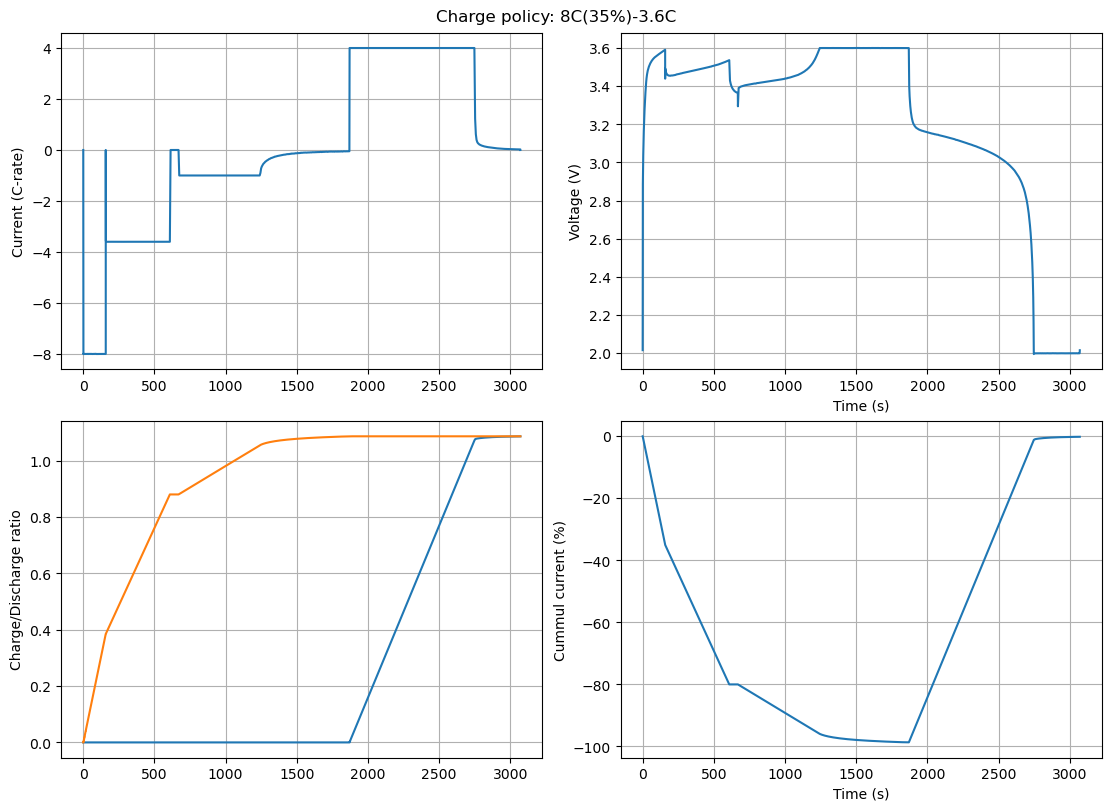

In [58]:
def nth_cycle_data(severson_cycle_data, n_index):
    # make things slightly more convinient
    return severson_cycle_data[str(n_index + 1)]

## inherit some cycle data and plot it
cyc = nth_cycle_data(batt_cycles, 1)
fig, (ax1,ax2) = plt.subplots(2,2, figsize=(11,8), constrained_layout=True)

fig.suptitle(f"Charge policy: {file['charge_policy']}")
# current
ax1[0].plot(cyc['t']*60, -cyc['I'])
ax1[0].set_ylabel("Current (C-rate)")
ax1[0].grid(True)
# voltage
ax1[1].plot(cyc['t']*60, cyc['V'])
ax1[1].set_ylabel("Voltage (V)")
ax1[1].set_xlabel("Time (s)")
ax1[1].grid(True)
# charge/discharge
ax2[0].plot(cyc['t']*60, cyc['Qd'])
ax2[0].plot(cyc['t']*60, cyc['Qc'])
ax2[0].set_ylabel("Charge/Discharge ratio")
ax2[0].grid(True)
# cummul current 
ax2[1].plot(cyc['t'][1:]*60, 100*np.cumsum(np.multiply( -cyc['I'][1:]/3600 , (cyc['t'][1:]-cyc['t'][0:-1])*60 )))
ax2[1].set_ylabel("Cummul current (%)")
ax2[1].set_xlabel("Time (s)")
ax2[1].grid(True)

## Init Pybamm

Começamos agora com uma simulação PyBaMM.  
PyBaMM vem pré-instalado com vários *parameter sets* da literatura, infelizmente não existem parametros de modelo para o dataset Severson. O mais próximo é o `Prada2013`, que também é uma bateria de química LFP-grafite. Abaixo alguns dados básicos do modelo:

| Parameter | Value |
| --- | --- | 
| Chemistry | LFP/graphite |
| Model | ANR26650m1 |
| Nominal capacity | 2.3 Ah |

É possível fazer ajustes manuais ao parametros de Prada para tornar a bateria em uma de 1.1Ah.  
Uma equação simplificada para capacidade de uma célula a partir de *first principles* é:
$$Q = c^{max}_i \cdot (\theta^{100\%}_i - \theta^{0\%}_i) \cdot \varepsilon_i^{a} \cdot L_i \cdot A_i \cdot \mathcal{F} \cdot \frac{1\text{ Ah}}{3600\text{ C}}$$

Onde...
- $i$ é o eletrodo limitante ($n$ se negativo, $p$ se positivo);
- $c^{max}$ é a concentração máxima, em [$\text{mol}\cdot m^{-3}$];
- $\theta$ é a *stoechiometry*, a fração de concentração no eletrodo quando SoC 100% e 0%;
- $\varepsilon_i^{a}$ é a fração de volume ocupado pelo material ativo;
- $L$ é a expessura do eletrodo, em [$m$];
- $A$ é a área do eletrode, em [$m^2$];
- $\mathcal{F}$ é a constante de faraday [$C\cdot\text{mol}^{-1}$];
- O último termo, $1/3600$, converte entre $C$ e $Ah$.

Stoechiometry não é um dos parâmetros pré-existentes no PyBaMM, porém, ele está listado no artigo de Prada 2013, na Tabela IV.  
Sendo que $\theta_n^{100\%} = 0.811$ e $\theta_n^{0\%} = 0.0132$...

---
- [Prada, Eric, et al.](https://iopscience.iop.org/article/10.1149/2.053304jes) "A simplified electrochemical and thermal aging model of LiFePO4-graphite Li-ion batteries: power and capacity fade simulations." Journal of The Electrochemical Society 160.4 (2013): A616.

In [59]:
import pybamm
param_vals = pybamm.ParameterValues("Prada2013")

stoe_1 = 0.811
stoe_0 = 0.0132
cap = param_vals["Maximum concentration in negative electrode [mol.m-3]"] * (stoe_1 - stoe_0) * \
      param_vals["Negative electrode active material volume fraction"] * \
      param_vals["Negative electrode thickness [m]"] *\
      param_vals["Electrode height [m]"] * param_vals["Electrode width [m]"] * \
      param_vals["Faraday constant [C.mol-1]"] * 1/3600

print(f"Capacidade {cap} [A.h] ({100*cap/param_vals['Nominal cell capacity [A.h]']:.2f}% do esperado)")

Capacidade 2.31907359518121 [A.h] (100.83% do esperado)


O insight importante é o seguinte:  
Desses, o que pode ser modificado ser mudar a propriedades químicas e dinâmicas da simulação é a área ($A$, depende de *height* e *width*). No modelo DFN(), considera-se o movimente de particulas ao longo do eixo $x$ (expessura da célula $L$)

In [107]:
# update de valores
param_vals["Negative particle diffusivity [m2.s-1]"] = 3E-13 # see https://github.com/pybamm-team/PyBaMM/discussions/4481
param_vals["Electrode height [m]"] = pybamm.ParameterValues("Prada2013")["Electrode height [m]"] * np.sqrt(1.1/2.3)
param_vals["Electrode width [m]"] = pybamm.ParameterValues("Prada2013")["Electrode width [m]"] * np.sqrt(1.1/2.3)
param_vals["Nominal cell capacity [A.h]"] = 1.1

cap = param_vals["Maximum concentration in negative electrode [mol.m-3]"] * (stoe_1 - stoe_0) * \
      param_vals["Negative electrode active material volume fraction"] * \
      param_vals["Negative electrode thickness [m]"] *\
      param_vals["Electrode height [m]"] * param_vals["Electrode width [m]"] * \
      param_vals["Faraday constant [C.mol-1]"] * 1/3600

print(f"Capacidade {cap} [A.h] ({100*cap/param_vals['Nominal cell capacity [A.h]']:.2f}% do esperado)")

Capacidade 1.1091221542171006 [A.h] (100.83% do esperado)


### Preparar simulação
Vamos simular o modelo DFN considerando o `file` de `i=3`.

Na minha experiência, existe risco de instabilidade quando se usa-se correntes muito altas. Esse é um teste inicial

In [108]:
# get file
i = 3
file = pd.read_pickle(os.path.join(DIR_PATH, files[i]))
print(f"Index {i} charge policy: {file['charge_policy']}")

Index 3 charge policy: 5.4C(40%)-3.6C


In [109]:
import re

def parse_charge_policy(policy_string: str):
    # ai generated, find values in policy string
    pattern = r"(\d+\.?\d*)C\((\d+\.?\d*)%\)-(\d+\.?\d*)C"
    match = re.search(pattern, policy_string)

    if match:
        values=[float(v) for v in match.groups()]
        return (values[0], values[1], values[2])
    else:
        return None
    
# some test
print(parse_charge_policy("5.4C(40%)-3.6C"))
print(parse_charge_policy("4C(42.4%)-3C"))
print(parse_charge_policy("4C (40%)-3C"))

(5.4, 40.0, 3.6)
(4.0, 42.4, 3.0)
None


In [110]:
# prepare pybamm - init experiment
(c1, soc_q1, c2) = parse_charge_policy(file['charge_policy'])
experiment = pybamm.Experiment([(
    "Discharge at 2C until 2.2V",
    "Hold at 2.2V until C/50", 
    "Rest for 1 minute",
    f"Charge at {c1} C for {soc_q1/100/c1} hours or until 3.6V",
    f"Charge at {c2} C for {(80-soc_q1)/100/c2} hours or until 3.6V",
    "Rest for 1 minute",
    "Charge at 1C until 3.6V",
    "Hold at 3.6V until C/50"
)])

xp = pybamm.Experiment([(
    "Discharge at 1C until 2.1V",
    "Hold at 2.0V until C/50"
)], temperature=300)

In [111]:
# init model and simulate
model = pybamm.lithium_ion.DFN()
sim = pybamm.Simulation(model, 
                        experiment=xp, 
                        solver=pybamm.CasadiSolver("safe"))
sim.solve()
sim.plot()

2025-06-10 11:14:18.551 - [WARNING] callbacks.on_experiment_infeasible_event(252): 

	Experiment is infeasible: 'event: Minimum voltage [V]' was triggered during 'Discharge at 1C until 2.1V'. The returned solution only contains up to step 1 of cycle 1. 


interactive(children=(FloatSlider(value=0.0, description='t', max=1.0463663613932097, step=0.01046366361393209…

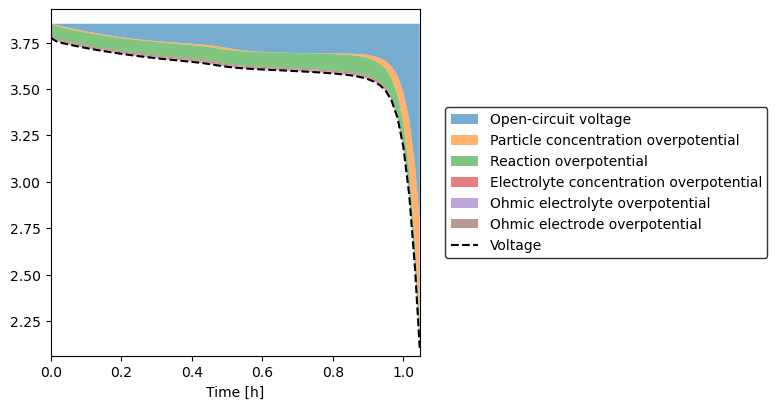

Lower voltage cut-off [V]	2.0
Open-circuit voltage at 0% SOC [V]	2.0
Open-circuit voltage at 100% SOC [V]	3.6
Upper voltage cut-off [V]	3.6


In [112]:
sim.solution.plot_voltage_components()
param_vals.search("Voltage")